This notebook provides a tutorial for the code used in the paper "Latent circuit inference from heterogeneous neural responses during cognitive tasks", Langdon and Engel 2022.

In [47]:
from net import *
from latent_net import *
from plotting_functions import *

## Train RNN on context-dependent decision-making task

#### Generate inputs (u) and targets (z) for the context-dependent decision-making task used in Siegel et al. Also generate a mask that restricts where in the trial errors are penalized.

In [54]:
from Tasks.SiegelMillerTask import *
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)

#### Initialize and fit RNN model with 50 units and Dales Law constraint.

In [57]:
net = Net(n=50, input_size=6, dale=True, sigma_rec=0.15 )
net.fit(u, z, mask, lr=.01,
        epochs=50, 
        verbose=True, 
        weight_decay=0.001)
# Note: Due to random initialization of network parameters, not every run will result in a successful network.

Epoch: 5/50............. mse_z: 0.0407
Epoch: 10/50............. mse_z: 0.0403
Epoch: 15/50............. mse_z: 0.0393
Epoch: 20/50............. mse_z: 0.0306
Epoch: 25/50............. mse_z: 0.0074
Epoch: 30/50............. mse_z: 0.0194
Epoch: 35/50............. mse_z: 0.0114
Epoch: 40/50............. mse_z: 0.0173
Epoch: 45/50............. mse_z: 0.0051
Epoch: 50/50............. mse_z: 0.0158


#### Visualize connectivity parameters of RNN after training

<AxesSubplot:>

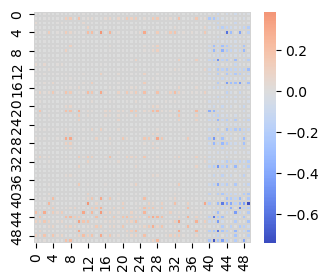

In [58]:
plt.figure(figsize=(3.5,3))
sns.heatmap( net.recurrent_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')

#### Plot psychometric functions for trained RNN

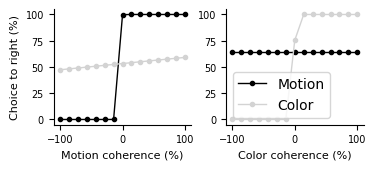

In [59]:

u, _, _, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(net,u,conditions)

## Fit latent circuit model to trained RNN

#### Initialize and fit latent circuit model

In [60]:
# Initialize
latent_net = LatentNet(n=8, N=net.n ,input_size=6, n_trials = u.shape[0],sigma_rec = 0.15)

# Generate inputs to simulate RNN
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
# Simulate RNN
y = net(u)
z = net.output_layer(y)
# Fit latent circuit model
loss_history = latent_net.fit(u.detach(),z.detach(),y.detach(),epochs = 500,lr = .02,l_y = 1,weight_decay = 0.001)

Epoch: 0/500............. mse_z: 0.2707 nmse_y: 1.0210
Epoch: 10/500............. mse_z: 0.1133 nmse_y: 0.2459
Epoch: 20/500............. mse_z: 0.0477 nmse_y: 0.1517
Epoch: 30/500............. mse_z: 0.0307 nmse_y: 0.1051
Epoch: 40/500............. mse_z: 0.0268 nmse_y: 0.0995
Epoch: 50/500............. mse_z: 0.0274 nmse_y: 0.1081
Epoch: 60/500............. mse_z: 0.0215 nmse_y: 0.0855
Epoch: 70/500............. mse_z: 0.0219 nmse_y: 0.0886
Epoch: 80/500............. mse_z: 0.0203 nmse_y: 0.0848
Epoch: 90/500............. mse_z: 0.0236 nmse_y: 0.0990
Epoch: 100/500............. mse_z: 0.0194 nmse_y: 0.0842
Epoch: 110/500............. mse_z: 0.0217 nmse_y: 0.0933
Epoch: 120/500............. mse_z: 0.0203 nmse_y: 0.0832
Epoch: 130/500............. mse_z: 0.0258 nmse_y: 0.0998
Epoch: 140/500............. mse_z: 0.0219 nmse_y: 0.0906
Epoch: 150/500............. mse_z: 0.0192 nmse_y: 0.0804
Epoch: 160/500............. mse_z: 0.0194 nmse_y: 0.0832
Epoch: 170/500............. mse_z: 0.0222 

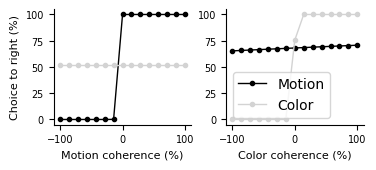

In [61]:
# Plot psychometric functions
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(latent_net,u,conditions)

<AxesSubplot:>

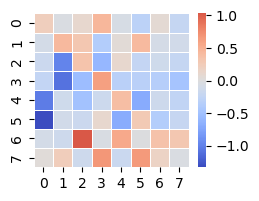

In [62]:
plt.figure(figsize=(2.5,2))
w_rec  = latent_net.recurrent_layer.weight.data.detach()
sns.heatmap(w_rec,center=0,cmap='coolwarm',linewidths=.5)

## Assessing fit quality of latent circuit model
There are several ways to assess the quality of fit of the latent circuit model.
1) Agreement between $Qx$ and $y$ where $x$ is the responses of the latent model, $y$ is the responses of the RNN and $Q$ is the orthonormal matrix that maps $x$ onto $y$.
2) Agreement between $x$ and $Q^Ty$ i.e. agreement in the subspace spanned by the columns of $Q$.
3) Agreement between $w_{rec}$ and $Q^TW_{rec}$.

#### 1) Agreement between $Qx$ and $y$

(-0.2590978920459747, 1.241301941871643)

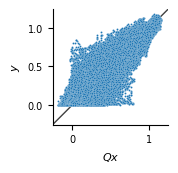

In [63]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
y  = net(u).detach()
qx = latent_net(u)@latent_net.q
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =qx.detach().flatten(),y = y.flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$Qx$", fontsize=8)
ax.set_ylabel(r"$y$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 2) Agreement between $x$ and $Q^Ty$

(-0.39969963431358335, 2.1439626216888428)

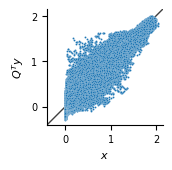

In [64]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
qty  = net(u).detach()@latent_net.q.t()
x = latent_net(u)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =x.detach().flatten(),y = qty.detach().flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$x$", fontsize=8)
ax.set_ylabel(r"$Q^Ty$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$

Text(0.5, 1.0, '$Q^Tw_{rec}Q$')

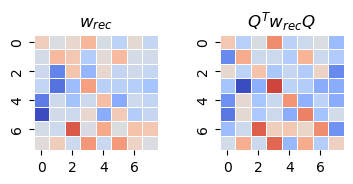

In [65]:
w_rec = latent_net.recurrent_layer.weight.data.detach()
q = latent_net.q.detach()
W_rec = net.recurrent_layer.weight.data.detach()

# Plot
fig = plt.figure(figsize=(4,1.5))
gs = gridspec.GridSpec(1,2,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])

sns.heatmap(w_rec, ax=ax0, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax0.set_title(r"$w_{rec}$")
sns.heatmap(q@W_rec@q.T, ax=ax1, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax1.set_title(r"$Q^Tw_{rec}Q$")